In [21]:
using Revise
using DataFrames
using CSV
using Query
# using Missings
using Clustering
using Distances
using MultivariateStats
using Statistics
using Plots
gr(fmt="png", size=(256, 256))
# pyplot()
# plotlyjs()

Plots.GRBackend()

In [23]:
rawdata_archive = CSV.read("../../Result/Chen Zhou/auc/bandpower_auc_archive.csv", allowmissing=:none, types=Dict([1=>String]))
@show size(rawdata_archive)
# head(rawdata)

rawdata = CSV.read("../../Result/Chen Zhou/auc/bandpower_auc.csv", allowmissing=:none, types=Dict([1=>String]))
@show size(rawdata)
head(rawdata)

size(rawdata_archive) = (10375, 11)
size(rawdata) = (10250, 11)


,exp,channel,id,mode,delta,theta,alpha,beta,lowgamma,highgamma,highpass
1,180821-1-10,1,180821-1-10-ch001,grating,-0.729113,-0.33112,-0.155845,-0.14659,-0.0964217,-0.0159311,-0.00514393
2,180821-1-10,2,180821-1-10-ch002,grating,-1.06284,-1.26274,-1.94051,-0.45067,1.1044,1.63215,1.32702
3,180821-1-10,3,180821-1-10-ch003,grating,-0.563663,-0.65765,-1.77367,-0.956806,0.722655,1.47335,1.45409
4,180821-1-10,4,180821-1-10-ch004,grating,0.204119,-1.34583,-1.9353,-1.13938,0.616232,1.78918,1.59652
5,180821-1-10,5,180821-1-10-ch005,grating,-0.841086,-1.82409,-1.75458,-0.712153,0.739591,1.68976,1.1877
6,180821-1-10,6,180821-1-10-ch006,grating,-0.80954,-1.80993,-1.752,-0.702271,0.763371,1.76417,1.19795


size(grating_reaction) = (5125, 7)
size(projM_grating) = (5125, 5)
size(entrain_reaction) = (5125, 7)
size(projM_entrain) = (5125, 5)


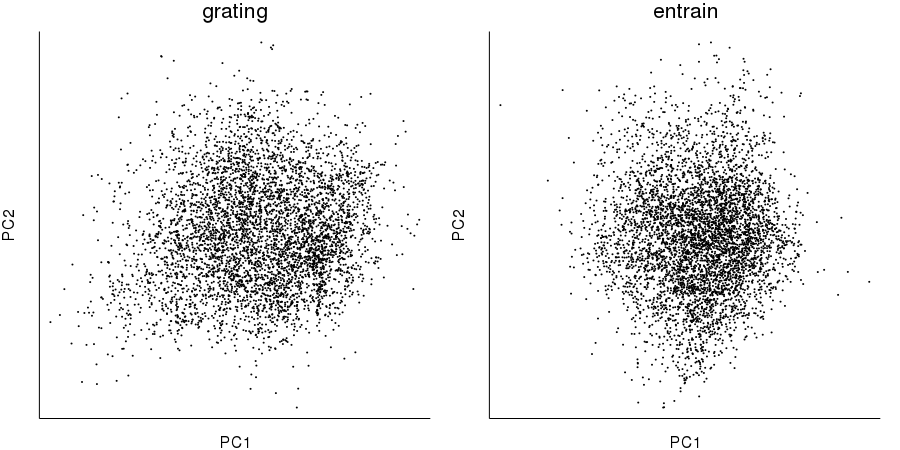

In [22]:
grating_sheet = @from i in rawdata begin
    @where i.mode == "grating"
    @select i
    @collect DataFrame
end
grating_reaction = grating_sheet[5:11] |> DataFrames.columns |> (x) -> hcat(x...)
grating_reaction[isnan.(grating_reaction)] .= 0.0
@show size(grating_reaction)

M_grating = fit(PCA, grating_reaction)
projM_grating = projection(M_grating)
@show size(projM_grating)

entrain_sheet = @from i in rawdata begin
    @where i.mode == "entrain"
    @select i
    @collect DataFrame
end
entrain_reaction = entrain_sheet[5:11] |> DataFrames.columns |> (x) -> hcat(x...)
entrain_reaction[isnan.(entrain_reaction)] .= 0.0
@show size(entrain_reaction)

M_entrain = fit(PCA, entrain_reaction)
projM_entrain = projection(M_entrain)
@show size(projM_entrain)

#-----

a = scatter(projM_grating[:,1], projM_grating[:,2], markersize=1.5, legend=false, 
    markerstrokewidth=0, color=:black, size=(500,400),
    xlabel="PC1", ylabel="PC2", title="grating", xtick=[], ytick=[])

b = scatter(projM_entrain[:,1], projM_entrain[:,2], markersize=1.5, legend=false, 
    markerstrokewidth=0, color=:black, size=(500,400),
    xlabel="PC1", ylabel="PC2", title="entrain", xtick=[], ytick=[])

plot(a,b, size=(900,450))
# savefig("PCA_scatter.png")

# K-means

  2.166041 seconds (3.10 M allocations: 152.917 MiB, 5.44% gc time)
  0.009398 seconds (1.88 k allocations: 1.238 MiB)


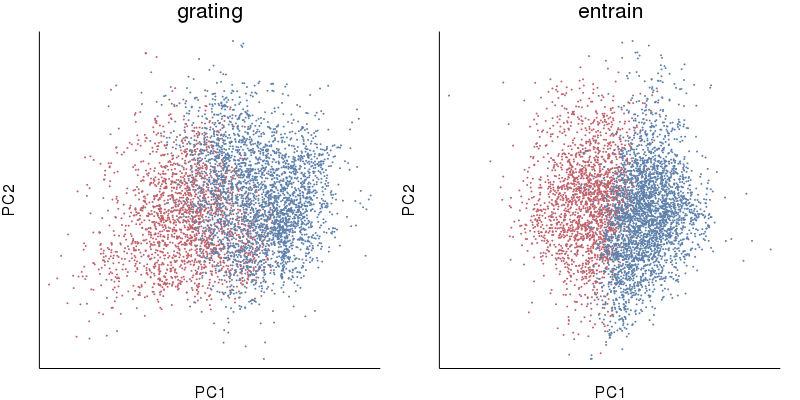

In [4]:
# @time R = kmeans(projM[:,1:2]', 2)
kn = 2
@time R_grating = grating_reaction' |> Array{Float64} |> (x) -> kmeans(x, kn)
@time R_entrain = entrain_reaction' |> Array{Float64} |> (x) -> kmeans(x, kn)

group_colormap = ["#bf616a", "#5e81ac"]

plot(legend=false, size=(500, 400))
for groupidx = 1:kn
    groupitem = findall((x)->x==groupidx, assignments(R_grating))
    scatter!(projM_grating[groupitem,1], projM_grating[groupitem,2], markersize=1.5, markerstrokewidth=0, color=group_colormap[groupidx])
end
# scatter!(R.centers[:,1], R.centers[:,2], markershape=:+, color=:black, markersize=10)
a = plot!(xlabel="PC1", ylabel="PC2", title="grating", xtick=[], ytick=[])

plot(legend=false, size=(500, 400))
for groupidx = 1:kn
    groupitem = findall((x)->x==groupidx, assignments(R_entrain))
    scatter!(projM_entrain[groupitem,1], projM_entrain[groupitem,2], markersize=1.5, markerstrokewidth=0, color=group_colormap[groupidx])
end
# scatter!(R.centers[:,1], R.centers[:,2], markershape=:+, color=:black, markersize=10)
b = plot!(xlabel="PC1", ylabel="PC2", title="entrain", xtick=[], ytick=[])

plot(a,b,size=(800,400))
# savefig("kmeans_scatter.png")

## loc

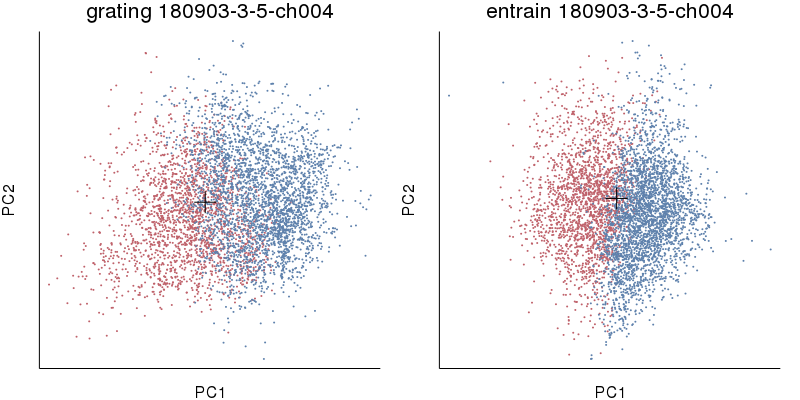

In [5]:
target_id = "180903-3-5-ch004"

pos = findall(grating_sheet[3] .== target_id)[1]

group_colormap = ["#bf616a", "#5e81ac"]

plot(legend=false, size=(500, 400))
for groupidx = 1:kn
    groupitem = findall((x)->x==groupidx, assignments(R_grating))
    scatter!(projM_grating[groupitem,1], projM_grating[groupitem,2], markersize=1.5, markerstrokewidth=0, color=group_colormap[groupidx])
end
scatter!(projM_grating[pos,1:1], projM_grating[pos,2:2], markershape=:+, color=:black, markersize=10)
a = plot!(xlabel="PC1", ylabel="PC2", title="grating "*target_id, xtick=[], ytick=[])

plot(legend=false, size=(500, 400))
for groupidx = 1:kn
    groupitem = findall((x)->x==groupidx, assignments(R_entrain))
    scatter!(projM_entrain[groupitem,1], projM_entrain[groupitem,2], markersize=1.5, markerstrokewidth=0, color=group_colormap[groupidx])
end
scatter!(projM_entrain[pos,1:1], projM_entrain[pos,2:2], markershape=:+, color=:black, markersize=10)
b = plot!(xlabel="PC1", ylabel="PC2", title="entrain "*target_id, xtick=[], ytick=[])

plot(a,b,size=(800,400))

## read out

In [8]:
readout = @from i in grating_sheet[findall((x)->x==2, assignments(R_grating)), :] begin
    @where i.exp == "180901-2-5"
    @select i.channel-1
    @collect
end

readout |> unique |> sort

96-element Array{Int64,1}:
   0
   6
   7
   8
   9
  10
  11
  12
  13
  14
  15
  16
  17
   ⋮
 113
 114
 115
 116
 117
 118
 119
 120
 121
 122
 123
 124

---
# DBSCAN

In [10]:
std(Distances.pairwise(Euclidean(), grating_reaction'))

0.9912569648430106

  0.722302 seconds (30.94 k allocations: 205.080 MiB, 8.25% gc time)
  0.814197 seconds (45.38 k allocations: 220.714 MiB, 21.15% gc time)


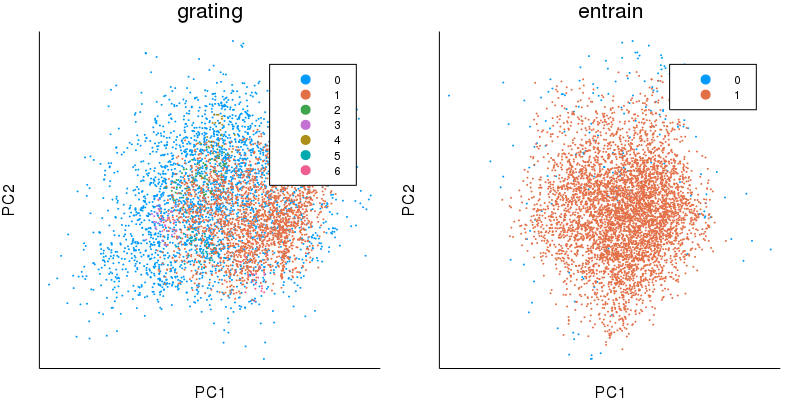

In [25]:
# @time R = kmeans(projM[:,1:2]', 2)
epsilon = 0.6
minPts = 30

@time D_grating = dbscan(Distances.pairwise(Euclidean(), grating_reaction'), epsilon, minPts)
@time D_entrain = dbscan(Distances.pairwise(Euclidean(), entrain_reaction'), epsilon, minPts)
# group_colormap = ["#bf616a", "#5e81ac"]

plot()
for groupidx = 1:size(unique(D_grating.assignments), 1)
    groupitem = findall((x)->x==groupidx-1, assignments(D_grating))
    scatter!(projM_grating[groupitem,1], projM_grating[groupitem,2], markersize=1.5, markerstrokewidth=0, label=groupidx-1)
end
a = plot!(xlabel="PC1", ylabel="PC2", title="grating ", xtick=[], ytick=[])


plot()
for groupidx = 1:1:size(unique(D_entrain.assignments), 1)
    groupitem = findall((x)->x==groupidx-1, assignments(D_entrain))
    scatter!(projM_entrain[groupitem,1], projM_entrain[groupitem,2], markersize=1.5, markerstrokewidth=0, label=groupidx-1)
end
b = plot!(xlabel="PC1", ylabel="PC2", title="entrain ", xtick=[], ytick=[])

plot(a,b,size=(800,400))
# savefig("DBSCAN_scatter.png")

## read out

In [24]:
readout = @from i in grating_sheet[findall((x)->x==1, assignments(D_grating)), :] begin
    @where i.exp == "180903-3-5"
    @select i.channel-1
    @collect
end

readout |> unique |> sort

16-element Array{Int64,1}:
   0
  10
  14
  15
  19
  29
  35
  45
  82
  83
  84
 101
 113
 122
 123
 124

# Hierarchical Clustering

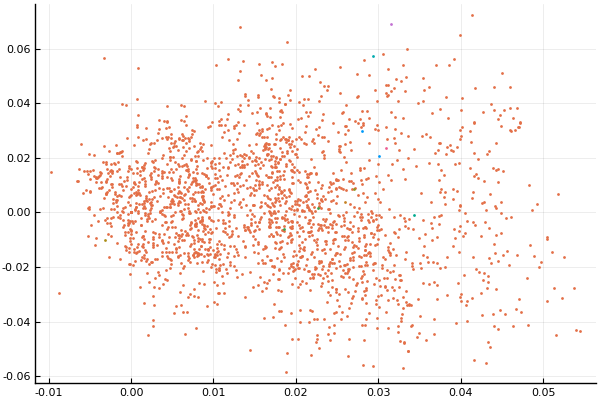

In [268]:
H = hclust(Distances.pairwise(Euclidean(), projM'), :single)
A = cutree(H, k=10)

plot(legend=false)
for groupidx = 1:10
    groupitem = find((x)->x==groupidx, A)
    scatter!(projM[groupitem,1], projM[groupitem,2], markersize=2, markerstrokewidth=0)
end
# scatter!(R.centers[:,1], R.centers[:,2], markershape=:+, color=:black, markersize=10)
plot!()

---
# misc
